PROJET TUTEURE : 
Réseaux de neurones : contact Gilles Michel : gilles.michel@sudintralog.com 
Récupération sur Yahoo Finances, par API, des cours de clôture d'une liste d'actions contenues  dans un fichier CSV, depuis le 1er janvier au 31 décembre 2021. 
Stocker ces cours dans une  base de données. Utiliser un réseau de neurones sur la période du 01/01/2022 au 31/08/2022 pour prédire le cours ou le sens d'évolution de chaque action du 01/09/2022 au 31/12/2022.  
Générer un fichier CSV par action représentant une simulation de trading sur la période du  01/09/2022 au 31/12/2022 avec une base de 1 million d'euros par action au 01/09/2022. On  prendra des frais de broker de 0.01€.

Pour réaliser ce projet avec la nouvelle liste d'actions et les critères spécifiés, nous allons structurer le code en étapes bien définies. Voici le plan détaillé avec l'implémentation de chaque étape.

Étape 1 : Récupération des données de clôture des actions
Nous allons utiliser l'API Yahoo Finance pour récupérer les données de clôture des actions listées dans la période du 1er janvier 2021 au 31 décembre 2021.

In [1]:
import yfinance as yf
import pandas as pd

# Liste des actions et leurs détails
data = {
    "Symbol": ["AAPL", "MSFT", "GOOGL", "AMZN", "TSLA", "META", "NVDA", "BRK-B", "JPM", "JNJ"],
    "Name": ["Apple Inc.", "Microsoft Corporation", "Alphabet Inc.", "Amazon.com Inc.", "Tesla Inc.", "Meta Platforms Inc.", "NVIDIA Corporation", "Berkshire Hathaway Inc.", "JPMorgan Chase & Co.", "Johnson & Johnson"],
    "Index": ["S&P500"] * 10
}

actions_df = pd.DataFrame(data)

# Période de récupération des données
start_date = '2022-01-01'
end_date = '2022-12-31'

# Dictionnaire pour stocker les cours de clôture
closing_prices = {}

# Récupérer les données de clôture pour chaque action
for symbol in actions_df['Symbol']:
    ticker = yf.Ticker(symbol)
    hist = ticker.history(start=start_date, end=end_date)
    closing_prices[symbol] = hist['Close']

# Convertir en DataFrame
closing_prices_df = pd.DataFrame(closing_prices)

# Arrondir les données de prix à deux chiffres après la virgule
closing_prices_df = closing_prices_df.round(2)

# Stocker les données dans un fichier CSV
closing_prices_df.to_csv('closing_prices_2022.csv', index_label='Date')


En regardant les données, on voit une disparité sur l'évolution du cours de certaines actions (META en l'occurence) On pourrait penser que ceci est dû aux choix stratégiques de ces entreprises comme le stock split.  
En 2022, parmi les actions listées sur notre travail, les entreprises suivantes ont subi un stock split :  

- Amazon.com Inc. (AMZN) : Stock split en 2022 (20-for-1 split)  
- Alphabet Inc. (GOOGL) : Stock split en 2022 (20-for-1 split)  
- Tesla Inc. (TSLA) : Stock split en 2022 (3-for-1 split)  

Cependant, ceci n'est pas visible sur notre base de données car cet effet est deja pris en compte. L'action de META a tout simplement connu une année désastreuse.  

Visualisation l'évolution de l'action de META et de AMAZON au cours de l'année 2022.

Étape 2 : Préparation des données pour le réseau de neurones
Nous allons extraire les données nécessaires de notre CSV, préparer les données pour entraîner plusieurs modèles de réseaux de neurones et sélectionner le meilleur modèle basé sur les performances.

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
import numpy as np

# Charger les données de clôture
df = pd.read_csv('closing_prices_2022.csv', index_col='Date')

# Fonction pour préparer les données pour LSTM
def prepare_data(symbol, data, time_step=30):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data.values.reshape(-1, 1))
    X, y = [], []
    for i in range(time_step, len(scaled_data)):
        X.append(scaled_data[i-time_step:i, 0])
        y.append(scaled_data[i, 0])
    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler

# Fonction pour créer un modèle LSTM
def create_lstm_model():
    model = Sequential()
    model.add(Input(shape=(30, 1)))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Préparer et entraîner les modèles
models = {}
scalers = {}
for symbol in df.columns:
    X, y, scaler = prepare_data(symbol, df[symbol])
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    model = create_lstm_model()
    model.fit(X_train, y_train, batch_size=1, epochs=1, validation_data=(X_val, y_val))
    
    models[symbol] = model
    scalers[symbol] = scaler


176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0390 - val_loss: 0.0165
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0165 - val_loss: 0.0117
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0423 - val_loss: 0.0054
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0534 - val_loss: 0.0140
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0588 - val_loss: 0.0225
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0128 - val_loss: 0.0029
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0351 - val_loss: 0.0094
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0314 - val_loss: 0.0049
176/176 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0239 - val_loss: 0.0071
176/176 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0587 - val_loss: 0.0138


Étape 3 : Simulation de trading
Nous allons utiliser les modèles entraînés pour prédire les cours ou le sens d'évolution des actions du 1er septembre 2022 au 31 décembre 2022 et générer des fichiers CSV représentant une simulation de trading.

In [3]:
import os

# Période de prédiction
start_date_prediction = '2022-09-01'
end_date_prediction = '2022-12-31'

# Initialiser l'investissement et les frais de broker
initial_investment = 1000000  # 1 million d'euros
broker_fee = 0.01  # 0.01€ par transaction

# Assurez-vous que le dossier de résultats existe
result_dir = 'results'
os.makedirs(result_dir, exist_ok=True)

# Simuler le trading pour chaque action
for symbol in df.columns:
    # Récupérer les données de clôture pour la période de prédiction
    ticker = yf.Ticker(symbol)
    prediction_data = ticker.history(start=start_date_prediction, end=end_date_prediction)['Close']
    
    # Préparer les données pour prédiction
    scaler = scalers[symbol]
    inputs = scaler.transform(prediction_data.values.reshape(-1, 1))
    X_test = []
    for i in range(30, len(inputs)):
        X_test.append(inputs[i-30:i, 0])
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    # Prédire les cours
    model = models[symbol]
    predicted_prices = model.predict(X_test)
    predicted_prices = scaler.inverse_transform(predicted_prices)

    # Simuler le trading
    investment = initial_investment
    shares = 0
    trading_actions = []
    for i in range(1, len(predicted_prices)):
        current_price = round(prediction_data.iloc[i+30], 2)  # Arrondir le prix à 2 chiffres après la virgule
        if predicted_prices[i] > predicted_prices[i-1]:
            if shares == 0:  # Acheter
                shares = investment / current_price
                investment -= broker_fee
                trading_actions.append((prediction_data.index[i+30], 'Acheter', current_price, round(shares, 2), round(investment, 2)))
        elif predicted_prices[i] < predicted_prices[i-1]:
            if shares > 0:  # Vendre
                investment += shares * current_price
                investment -= broker_fee
                trading_actions.append((prediction_data.index[i+30], 'Vendre', current_price, round(shares, 2), round(investment, 2)))
                shares = 0

    # Générer le fichier CSV dans le dossier résultat
    trading_simulation = pd.DataFrame(trading_actions, columns=['Date', 'Action', 'Prix', 'Nombre d\'actions', 'Investissement'])
    csv_filename = os.path.join(result_dir, f'trading_simulation_{symbol}.csv')
    trading_simulation.to_csv(csv_filename, index=False)

    print(f"Simulation de trading pour {symbol} enregistrée dans : {csv_filename}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
Simulation de trading pour AAPL enregistrée dans : results\trading_simulation_AAPL.csv
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
Simulation de trading pour MSFT enregistrée dans : results\trading_simulation_MSFT.csv
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x0000027413088040> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for

Pour visualiser l'évolution du profit et perte (PnL) d'un ticker sélectionné parmi ceux utilisés, nous allons créer un script Python qui :

Charge le fichier CSV de la simulation de trading.  
Calcule le PnL au fil du temps.  
Visualise l'évolution du PnL, en utilisant des couleurs différentes pour les périodes de PnL positif et négatif.  
Nous utiliserons Matplotlib pour créer la visualisation.  


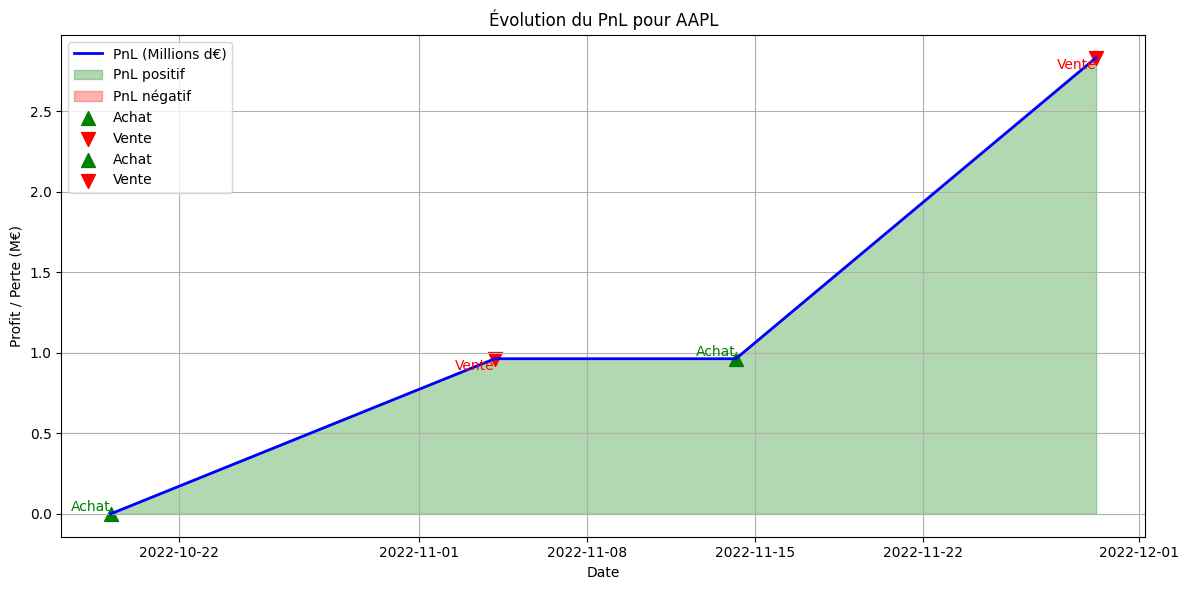

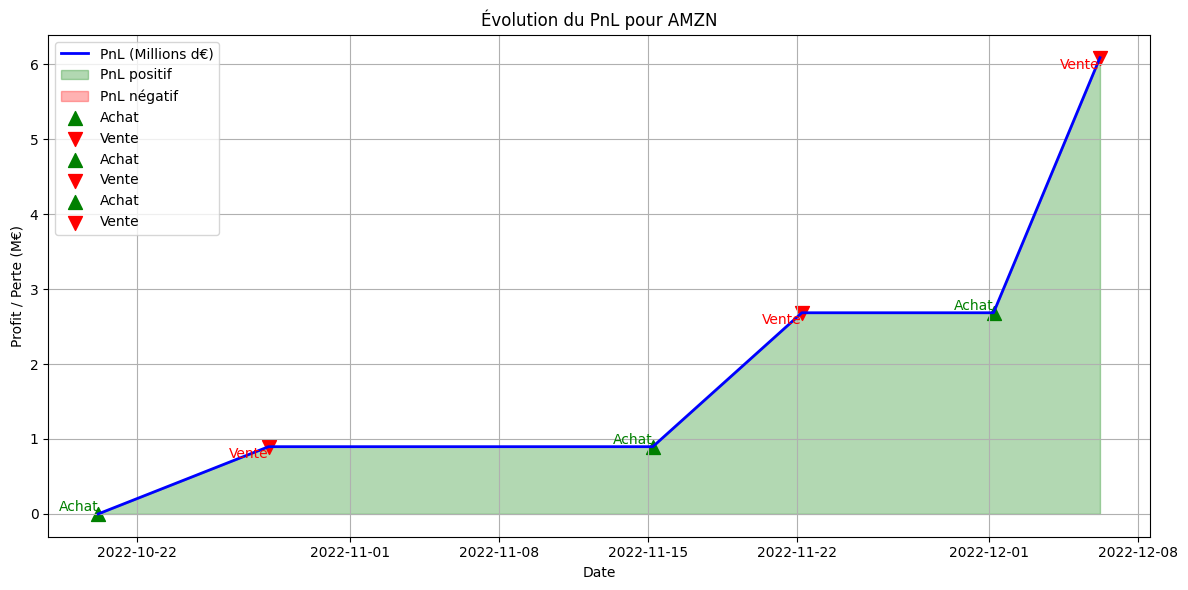

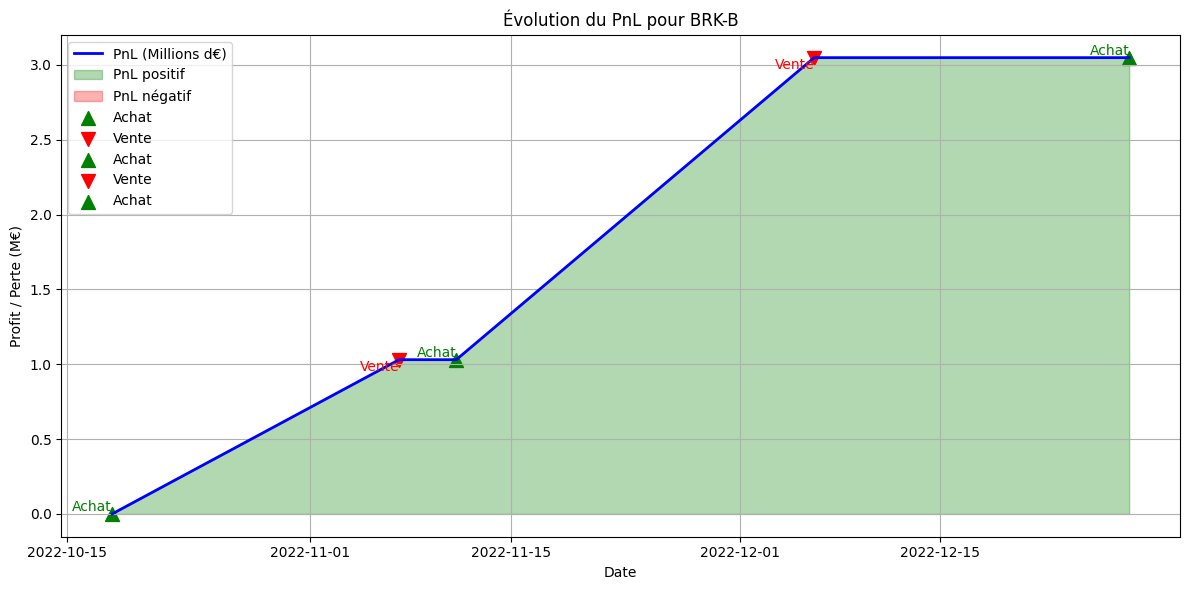

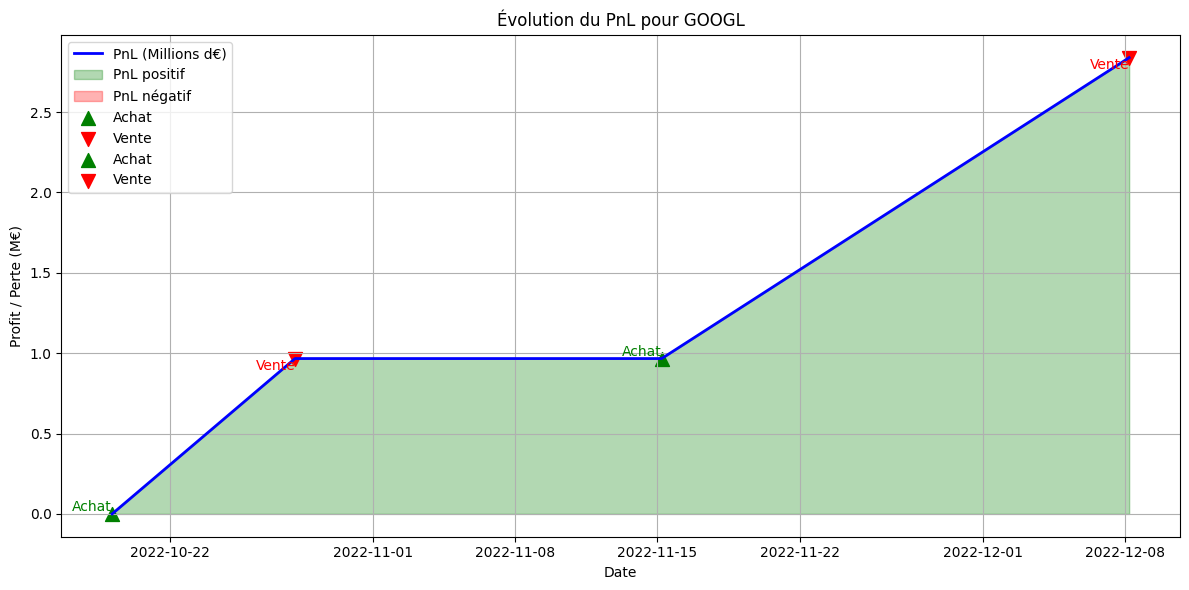

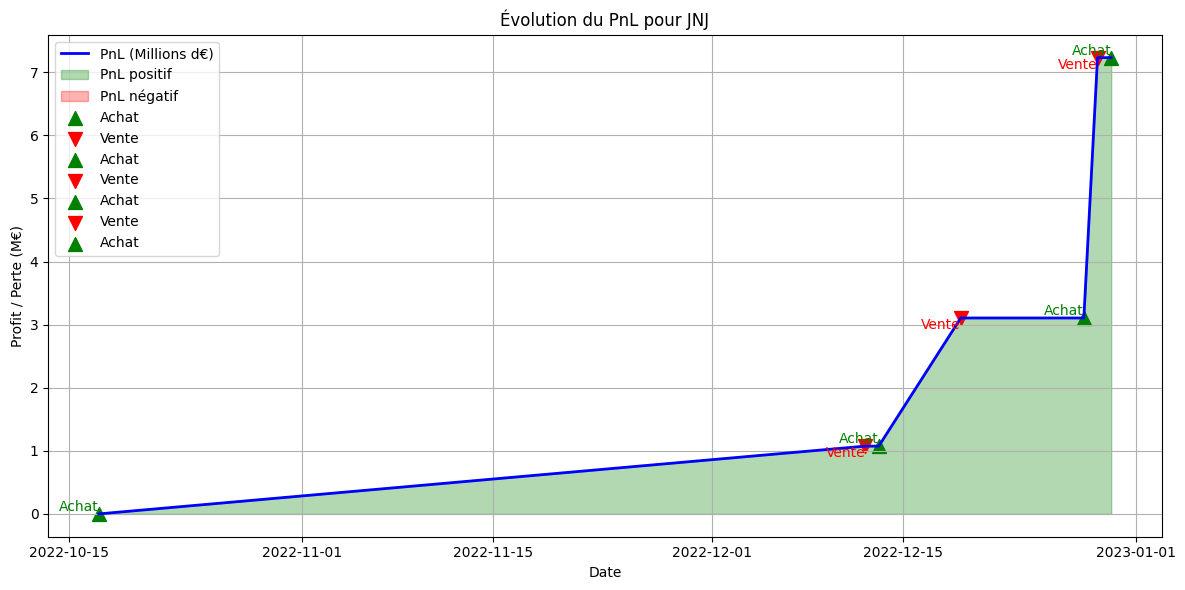

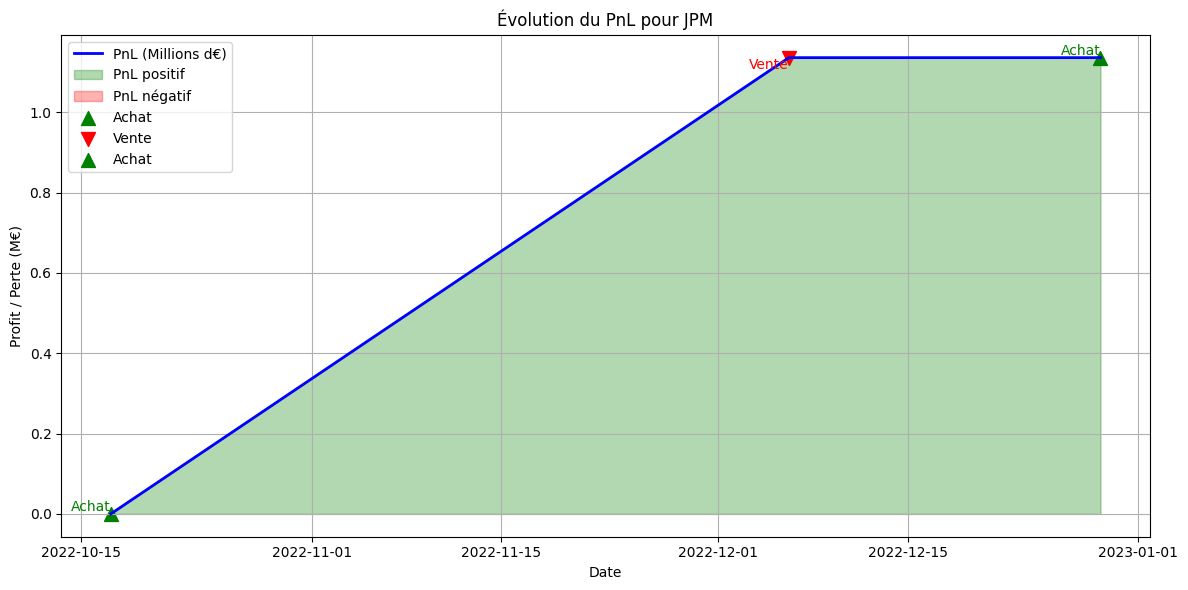

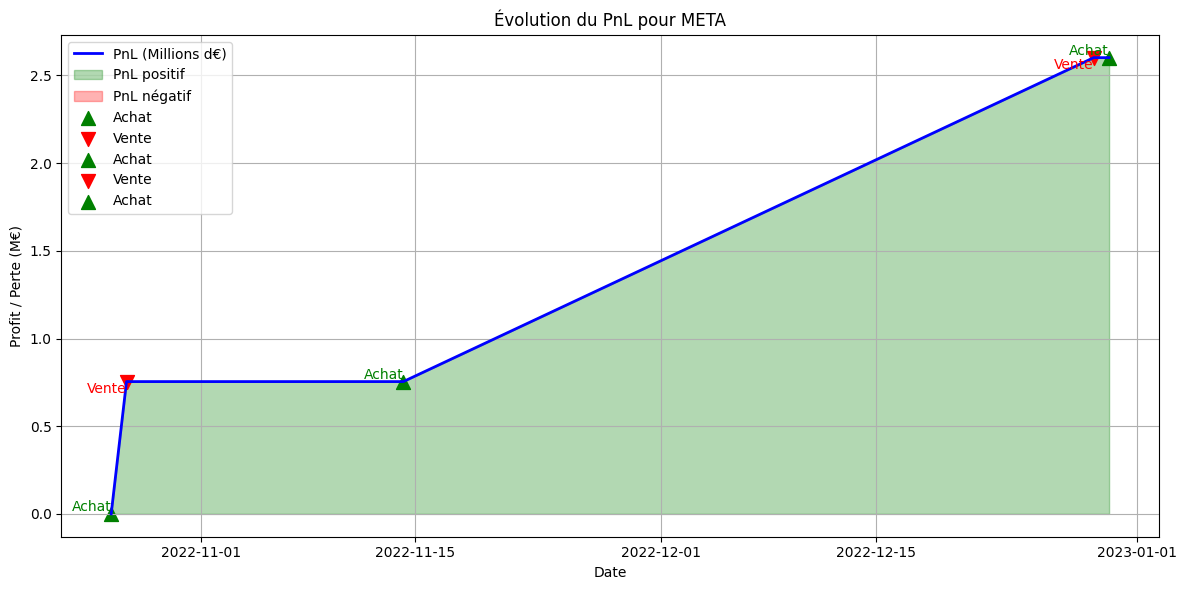

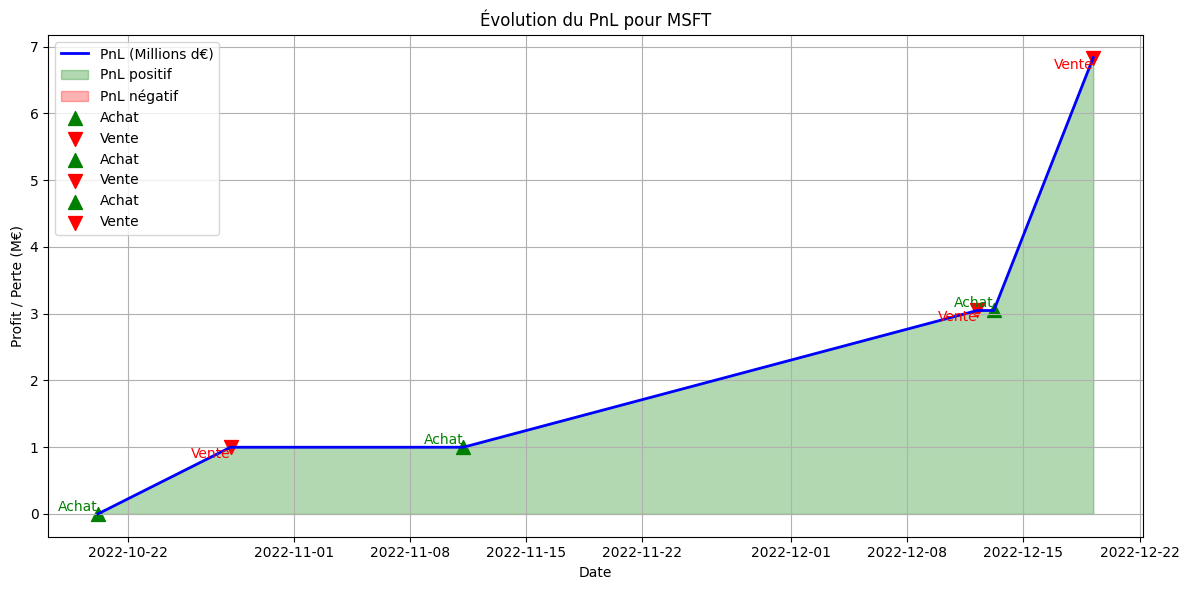

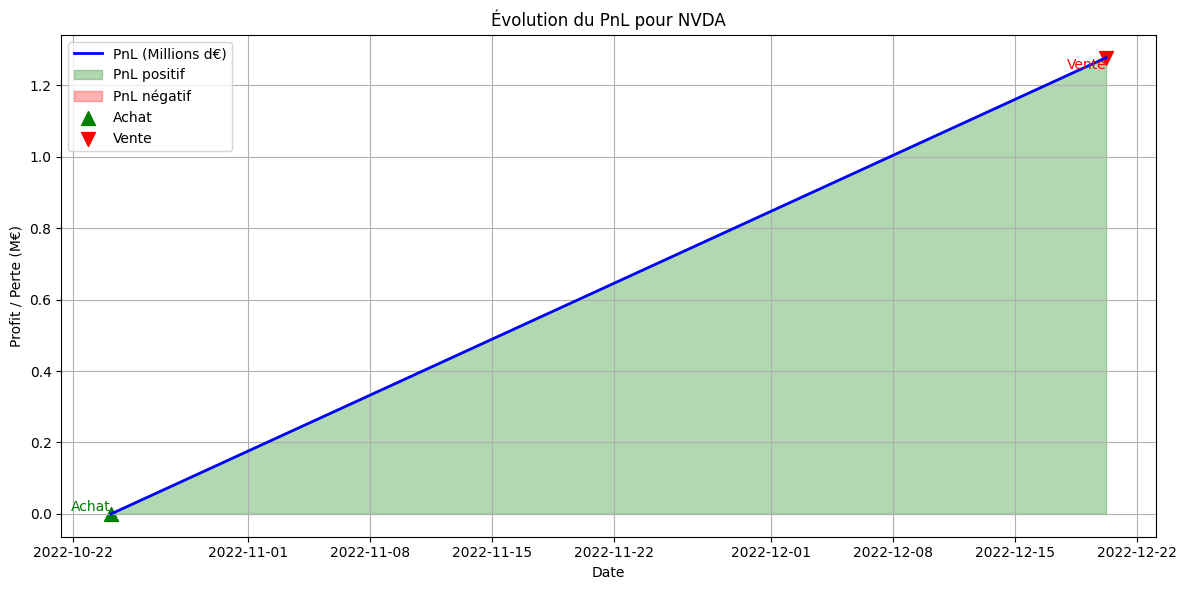

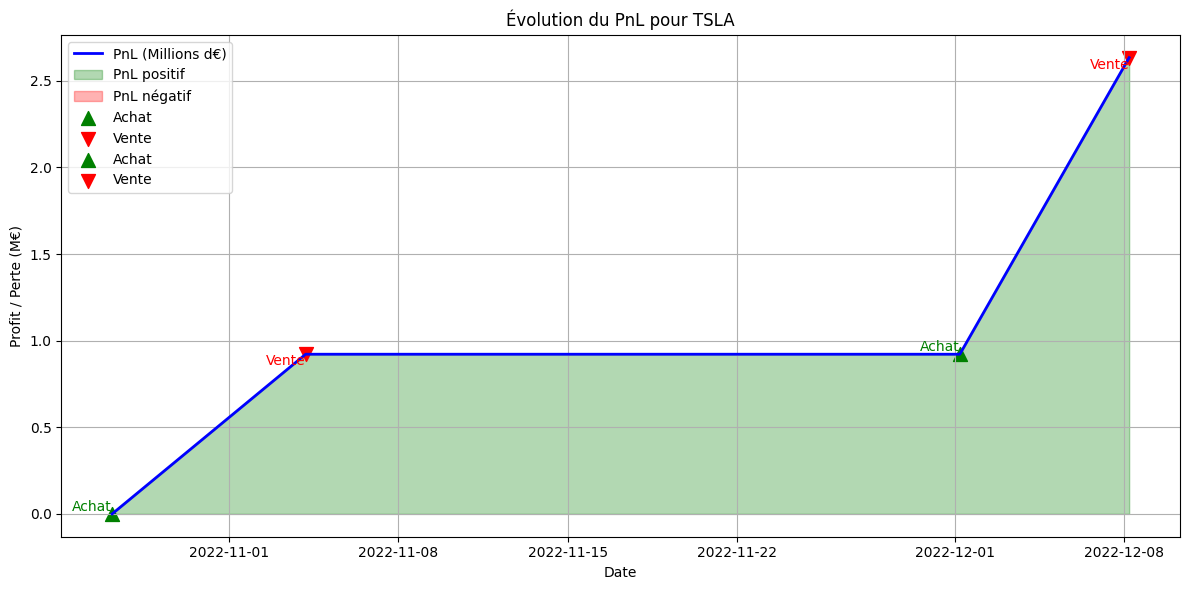

In [29]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates  # Import pour formater les dates

# Chemin vers le dossier contenant les fichiers CSV de simulation de trading
result_dir = 'results'

# Listage de tous les fichiers CSV dans le dossier
csv_files = [os.path.join(result_dir, f) for f in os.listdir(result_dir) if f.endswith('.csv')]

# Parcourir chaque fichier CSV
for csv_file in csv_files:
    # Charger le fichier CSV de simulation de trading
    df = pd.read_csv(csv_file)

    # Convertir la colonne 'Date' en datetime avec utc=True pour éviter le FutureWarning
    df['Date'] = pd.to_datetime(df['Date'], utc=True)

    # Calculer le PnL en millions d'euros
    df['PnL'] = (df['Investissement'] - df['Investissement'].iloc[0]) / 1000000  # Conversion en millions d'euros

    # Préparer les données pour la visualisation
    dates = df['Date']
    pnl_values = df['PnL']

    # Déterminer les périodes de PnL positif et négatif pour la coloration
    positive_pnl = pnl_values >= 0
    negative_pnl = pnl_values < 0

    # Extraire le symbole du fichier CSV
    symbol = os.path.splitext(os.path.basename(csv_file))[0].split('_')[-1]

    # Créer le graphique de l'évolution du PnL
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(dates, pnl_values, label='PnL (Millions d€)', color='blue', linewidth=2)
    ax.fill_between(dates, pnl_values, where=positive_pnl, interpolate=True, color='green', alpha=0.3, label='PnL positif')
    ax.fill_between(dates, pnl_values, where=negative_pnl, interpolate=True, color='red', alpha=0.3, label='PnL négatif')

    # Ajouter des marqueurs pour les dates d'achat et de vente
    for action in df.itertuples():
        if action.Action == 'Acheter':
            ax.scatter(action.Date, action.PnL, color='green', marker='^', s=100, label='Achat')
            ax.text(action.Date, action.PnL, 'Achat', verticalalignment='bottom', horizontalalignment='right', color='green')
        elif action.Action == 'Vendre':
            ax.scatter(action.Date, action.PnL, color='red', marker='v', s=100, label='Vente')
            ax.text(action.Date, action.PnL, 'Vente', verticalalignment='top', horizontalalignment='right', color='red')

    # Configurer le titre et les étiquettes des axes
    ax.set_title(f'Évolution du PnL pour {symbol}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Profit / Perte (M€)')
    ax.legend()
    ax.grid(True)

    # Formater les dates sur l'axe des x
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

    # Afficher le graphique
    plt.tight_layout()
    plt.show()


Pour visualiser l'évolution totale du portefeuille avec les 10 actions à partir des fichiers CSV générés, nous allons agréger les données de PnL de chaque action et les représenter sur un seul graphique. On va :  

Charger chaque fichier CSV.  
Calculer le PnL pour chaque action.  
Agréger les PnL pour obtenir le PnL total du portefeuille.  
Afficher les metrics du PnL total.  

In [28]:
# Listage de tous les fichiers CSV dans le dossier
csv_files = [os.path.join(result_dir, f) for f in os.listdir(result_dir) if f.endswith('.csv')]

# Variables pour stocker les résultats
total_pnl = 0
total_transaction_fees = 0
max_drawdown = 0
max_portfolio_value = 0

# Parcourir chaque fichier CSV
for csv_file in csv_files:
    # Charger le fichier CSV de simulation de trading
    df = pd.read_csv(csv_file)

    # Récupérer la dernière valeur de la colonne 'Investissement' pour le PnL
    final_investment_value = df['Investissement'].iloc[-1]

    # Calculer le PnL pour cet actif
    pnl = final_investment_value - 1000000  # Supposant que l'investissement initial est de 1 million d'euros
    total_pnl += pnl

    # Calculer le nombre total d'actions achetées et vendues
    total_transactions = df[df['Action'].isin(['Acheter', 'Vendre'])]['Nombre d\'actions'].sum()

    # Calculer le montant total des frais
    transaction_fees = total_transactions * 0.01  # 0.01€ par transaction
    total_transaction_fees += transaction_fees

    # Calculer le drawdown maximum
    max_value = df['Investissement'].max()
    drawdown = (max_value - final_investment_value) / max_value * 100
    if drawdown > max_drawdown:
        max_drawdown = drawdown

    # Calculer la valeur maximale du portefeuille
    if max_value > max_portfolio_value:
        max_portfolio_value = max_value

# Afficher les résultats
print(f"Total PnL sur la période: {total_pnl:.2f} €")
print(f"Montant total des frais sur la période: {total_transaction_fees:.2f} €")
print(f"Drawdown maximum: {max_drawdown:.2f}%")
print(f"Valeur maximale du portefeuille: {max_portfolio_value:.2f} €")


Total PnL sur la période: 36523083.15 €
Montant total des frais sur la période: 7568.60 €
Drawdown maximum: 0.00%
Valeur maximale du portefeuille: 8232095.54 €
